# Architecture

This notebook is used to design and test out architecture components variations.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl
from context_learning.utils import *

In [3]:
strategy = tfu.strategy.gpu(1)

In [4]:
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

y_train = np.array([
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 1, 1, 0], # NAND
    [1, 0, 0, 0], # NOR
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 1, 1], # Custom A
    [0, 1, 0, 1], # Custom B
])[..., np.newaxis]

In [5]:
BATCH_SIZE = 1

datasets = [] 
for y in y_train:
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    datasets.append(dist_dataset)
clear_output() # hide shard warnings

In [6]:
class ContextLayerBase(keras.layers.Layer):
    def __init__(self, switch_threshold, num_contexts=1, atr_size=None, switch_delay=0, auto_switch=True,
                 learn_rate=0.5, switch_init=None, init_mul=1.0, init_loss=None, verbose=0):
        super(ContextLayerBase, self).__init__(self)
        
        self.switch_init = switch_init
        self.init_mul = init_mul
        self.init_loss = init_loss
        self.learn_rate = learn_rate
        self.verbose = verbose
        
        # Contextualization
        self.num_contexts = num_contexts
        self.atr_size = atr_size
        self.switch_delay = switch_delay
        self.project = None
        self.hot_context = tf.Variable(0, name="Hot Context", trainable=False, dtype=tf.int32)
        
        # Switching mechanism
        self.auto_switch = auto_switch
        self.context_losses = tf.Variable(tf.zeros(num_contexts), dtype=tf.float32, trainable=False, name="Context Losses")
        self.switch_threshold = tf.Variable(switch_threshold, dtype=tf.float32, trainable=False, name="Switch Threshold")
        self.delayed_epochs = tf.Variable(switch_delay, dtype=tf.int32, trainable=False, name="Delayed Epochs")
        self.epoch_switched = tf.Variable(-1, dtype=tf.int32, trainable=False, name="Epoch Switched")
        self.num_seq_switches = tf.Variable(0, dtype=tf.int32, trainable=False, name="Sequential Switches")
        self.delta = tf.Variable(0.0, dtype=tf.float32, trainable=False, name="Loss Delta")
        self.delta_switched = tf.Variable(0.0, dtype=tf.float32, trainable=False, name="Delta Switched")
        
        # Track observed losses for each context (used to compute deltas and find best-fit contexts)
        self.observed_losses = tf.Variable(tf.zeros(num_contexts), dtype=tf.float32, trainable=False, name="Observed Loss Values")
        self.losses_initialized = tf.Variable(tf.zeros(num_contexts, dtype=tf.int8), dtype=tf.int8, trainable=False, name="Initialized Loss Values") # bool doesn't work yet...
        
    def build(self, input_shape):
        if self.atr_size is not None:
            self.project = keras.layers.Dense(self.atr_size)
        else:
            self.atr_size = input_shape[-1]
    
    def call(self, x):
        if self.project is not None:
            x = self.project(x)
        return self.contextualize(x)
    
    def contextualize(self, x):
        raise NotImplemented()
    
    def update_and_switch(self, epoch, absorb):
        return tf.cond(self.should_switch(epoch), lambda: self._switch(epoch, absorb), lambda: self._update(epoch, absorb))
        
    def should_switch(self, epoch):
        if not self.auto_switch:
            return False
        return tf.logical_and(
            self.delayed_epochs <= 0,
            tf.logical_and(
                self.losses_initialized[self.hot_context] == 1,
                self.compute_context_delta() < self.switch_threshold
            ))
    
    def _switch(self, epoch, absorb):
        # Before the switch...
        self.on_before_switch(epoch)
        
        # Count the switches
        self.num_seq_switches.assign_add(1)
        self.epoch_switched.assign(epoch)
        
        # Switch contexts and return the result
        self.switch_contexts(absorb)
        
        # Always return true to indicate a switch occurred
        return True
        
    def switch_contexts(self, absorb):
        def switch_to_best_fit():
            best_fit = self.find_best_fit_context()
            self.set_context(best_fit)
            self.update_context_loss(self.observed_losses[self.hot_context], absorb)
            if self.verbose > 0:
                tf.print("Switching to best-fit context:", best_fit)
        
        def switch_to_next():
            self.next_context()
            if self.verbose == 2:
                tf.print("\nSwitched to context:", self.hot_context)
            tf.cond(not self.losses_initialized[self.hot_context], self.reset_switch_delay, tf.no_op)
        
        # If we've tried all contexts and none fits well, use the best-fit. Otherwise, use the next context
        tf.cond(self.num_seq_switches >= self.num_contexts, switch_to_best_fit, switch_to_next)
        
    
    def _update(self, epoch, absorb):
        def update_counters():
            # Decrement the delayed epochs counter on absorbing states
            tf.cond(self.delayed_epochs > 0, lambda: self.delayed_epochs.assign_sub(1), tf.no_op)
            # Reset the sequence counter on absorbing states
            tf.cond(self.num_seq_switches != 0, lambda: self.num_seq_switches.assign(0), tf.no_op)
            
        # Before the context loss value is updated...
        # This is a sort of hack to skip updating delta
        # traces after a best-fit was found
        tf.cond(epoch != self.epoch_switched, self.on_before_update, tf.no_op)
        
        # Update the context-loss value
        self.update_context_loss(self.observed_loss(), absorb)
        
        # If obsorbing, update counters
        tf.cond(absorb, update_counters, tf.no_op)
        return False # Always return false to indicate no switch
    
    def observed_loss(self):
        return self.observed_losses[self.hot_context]
    
    def context_loss(self):
        return self.context_losses[self.hot_context]
    
    def compute_context_delta(self):
        return self.context_loss() - self.observed_loss()
    
    def add_observed_loss(self, observed_loss):
        loss = self.compute_observed_error(observed_loss)
        # indices = [tf.expand_dims(self.hot_context, 0)]
        self.observed_losses.scatter_nd_add([[self.hot_context]], loss)
        
    def clear_observed_loss(self):
        # indices = [tf.expand_dims(self.hot_context, 0)]
        self.observed_losses.scatter_nd_update([[self.hot_context]], [0.0])
                
    def compute_observed_error(self, observed_loss):
        return keras.losses.mean_squared_error(tf.zeros_like(observed_loss), observed_loss)
    
    def set_context_loss(self, context_loss, absorb):
        self.context_losses.scatter_nd_update([[self.hot_context]], [context_loss])
        tf.cond(not self.losses_initialized[self.hot_context] and absorb, lambda: self.losses_initialized.scatter_nd_update([[self.hot_context]], [1]), tf.no_op)
    
    def update_context_loss(self, context_loss, absorb, switched=False):
        def init_context_loss():
            init_loss = self.init_mul*context_loss
            if self.init_loss is not None:
                init_loss = tf.maximum(init_loss, self.init_loss)
            # tf.print("Initializing context loss...")
            self.set_context_loss(init_loss, absorb)
            
        def update_context_loss():
            direct_loss = lambda: context_loss
            delta_loss = lambda: self.context_loss() + self.learn_rate*(self.observed_loss() - self.context_loss())
            loss = tf.cond(switched, direct_loss, delta_loss)
            # tf.print("Updating context loss...")
            self.set_context_loss(loss, absorb)
        
        tf.cond(not self.losses_initialized[self.hot_context], init_context_loss, update_context_loss)
    
    def next_context(self):
        self.hot_context.assign((self.hot_context + 1) % self.num_contexts)
        
    def set_context(self, context):
        self.hot_context.assign(context)
        
    def find_best_fit_context(self):
        return tf.argmax((self.context_losses - self.observed_losses)[:self.num_contexts], output_type=tf.int32)
    
    def on_before_switch(self, epoch):
        def update_delta():
            delta = self.compute_context_delta()
            self.delta_switched.assign(delta)
            self.delta.assign(delta)
        tf.cond(epoch != self.epoch_switched, update_delta, tf.no_op)
    
    def on_before_update(self):
        def update_delta():
            delta = self.compute_context_delta()
            self.delta.assign(delta)
        tf.cond(self.losses_initialized[self.hot_context], update_delta, tf.no_op)
        
    def reset_switch_delay(self):
        if self.switch_delay == 0:
            return
        self.delayed_epochs.assign(self.switch_delay)
        if self.verbose:
            tf.print(f"\n[{self.name}] Unitialized context: Context switching disabled for {self._switch_delay} absorbing epochs.")

In [7]:
class ContextLayerLogHrr(ContextLayerBase):
    def __init__(self, *args, **kwargs):
        super(ContextLayerLogHrr, self).__init__(*args, **kwargs)
        
        # Contextualization
        self.num_atrs = int(np.ceil(np.log2(self.num_contexts)))
        
    def build(self, input_shape):
        super(ContextLayerLogHrr, self).build(input_shape)
        self.atrs = hrrs(self.atr_size, self.num_atrs)
    
    def contextualize(self, x):
        result = x
        for i in range(self.num_atrs):
            result = tf.cond(tf.bitwise.bitwise_and(self.hot_context, (1 << i)) > 0, lambda: self.convolve(i, result), lambda: result)
        return result
    
    def convolve(self, i, x):
        atr = tf.gather(self.atrs, i)
        return circular_conv(atr, x)

In [8]:
class ContextLayerConvPower(ContextLayerBase):
    def __init__(self, *args, **kwargs):
        super(ContextLayerConvPower, self).__init__(*args, **kwargs)
        
    def build(self, input_shape):
        super(ContextLayerConvPower, self).build(input_shape)
        self.context_hrr = hrr(self.atr_size)
    
    def contextualize(self, x):
        return circular_conv_power(x, self.context_hrr, self.hot_context)

In [11]:
from keras.engine import data_adapter

class ContextModelBase(keras.Model):
    def __init__(self, *args, retry_fit=True, verbose=0, **kwargs):
        super(ContextModelBase, self).__init__(*args, **kwargs)
        self.retry_fit = retry_fit
        self.verbose = verbose
        self.context_layer_map = [i for i, l in enumerate(self.layers) if isinstance(l, ContextLayerBase)]
        self.context_gradient_map = self._build_gradient_map()
        self.num_context_layers = tf.constant(len(self.context_layer_map))
        self.prev_epoch = tf.Variable(-1, dtype=tf.int32, trainable=False, name="Previous Epoch")
        
        # Set context layer verbosity
        for layer_id in self.context_layer_map:
            layer = self.layers[layer_id]
            layer.verbose = max(layer.verbose, verbose)
        
    def _build_gradient_map(self):
        gradient_map = []
        index = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ContextLayerBase):
                # Offset if we can use the bias weight
                offset = int(self.layers[i + 1].use_bias)
                
                # If there is a built-in projection layer, offset appropriately
                if layer.project is not None:
                    offset += len(layer.project.trainable_variables)
                
                gradient_map.append(index + offset)
            index += len(layer.trainable_variables)
        return gradient_map
            
    def _calc_context_loss(self, context_layer_id, gradients):
        """
        IMPORTANT:
        1) Assumes no use of activation function on Ntask layer
        2) Assumes that the layer following the Ntask layer:
            a) Is a Dense layer
            b) Is using bias
               — ex: Dense(20, ... , use_bias=True)
               — note Keras Dense layer uses bias by default if no value is given for use_bias param
        3) Assumes index of the next layer's gradient is known within the gradients list returned from gradient tape in a tape.gradient call
        4) If the above points aren't met, things will break and it may be hard to locate the bugs
        """
        # If we aren't using the bias, reduce the dimensionality using mean square
        layer_index = self.context_layer_map[context_layer_id]
        if len(gradients.shape) > 1:
            gradients = tf.reduce_mean(tf.multiply(gradients, gradients), axis=0)
        next_layer_weights =  tf.transpose(self.layers[layer_index + 1].weights[0])
        context_delta = tf.tensordot(tf.expand_dims(gradients, 0), next_layer_weights, 1)
        return context_delta
    
    def add_observed_loss(self, gradients):
        for i, grads in enumerate(gradients):
            observed_loss = self._calc_context_loss(i, grads)
            self.layers[self.context_layer_map[i]].add_observed_loss(observed_loss)
            
    # def clear_observed_loss(self):
    #     for layer_id in self.context_layer_map:
    #         self.layers[layer_id].clear_observed_loss()
            
    def backup(self):
        self._backup = keras.backend.batch_get_value(self.trainable_weights)
        # for layer_id in self.context_layer_map:
        #     self.layers[layer_id].backup()
        
    def restore(self):
        keras.backend.batch_set_value(zip(self.trainable_weights, self._backup))
        # for layer_id in self.context_layer_map:
        #     self.layers[layer_id].restore()
            
    def perform_epoch(self, epoch, absorb=True):
        def begin_epoch():
            self.prev_epoch.assign(epoch)
            self.backup()
            return True
        def update_and_switch():
            switched = False
            for i, layer_id in enumerate(self.context_layer_map):
                layer = self.layers[layer_id]
                switched = tf.logical_or(layer.update_and_switch(epoch, absorb), switched)
                layer.clear_observed_loss()
            tf.cond(switched, self.restore, tf.no_op)
            return switched
        return tf.cond(self.prev_epoch != epoch, begin_epoch, lambda: tf.logical_and(update_and_switch(), self.retry_fit))
    
class ContextModel(ContextModelBase):
    pass

In [12]:
ATR_SIZE = 128
SWITCH_THRESHOLD = -0.02
NUM_TASKS = 6

with strategy.scope():
    y = x = keras.layers.Input((2,))
    y = keras.layers.Dense(ATR_SIZE, activation="relu")(y)
    # y = ContextLayerBase(switch_threshold=SWITCH_THRESHOLD, num_contexts=NUM_TASKS, auto_switch=True)(y)
    # y = ContextLayerLogHrr(switch_threshold=SWITCH_THRESHOLD, num_contexts=NUM_TASKS, auto_switch=True)(y)
    y = ctl.ContextLayerConvPower(switch_threshold=SWITCH_THRESHOLD, num_contexts=NUM_TASKS, auto_switch=True, verbose=0)(y)
    # y = keras.layers.Dense(10, use_bias=True)(y)
    y = keras.layers.Dense(1, activation="sigmoid")(y)
    model = ctl.ContextModel(x, y, verbose=1)
    model.compile(
        optimizer=keras.optimizers.SGD(1e-1),
        loss=keras.losses.BinaryCrossentropy(from_logits=False))
    model.summary()
    # model.run_eagerly=True

Model: "context_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
context_layer_conv_power (Co (None, 128)               25        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 539
Trainable params: 513
Non-trainable params: 26
_________________________________________________________________


In [13]:
def train_step(model, batch):
    x = batch[0]
    y = batch[1]
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = model.compiled_loss(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    context_grads = [grads[i] for i in model.context_gradient_map]
    return context_grads, loss

@tf.function
def dist_train_step(model, batch):
    grads, losses = strategy.run(train_step, args=(model, batch,))
    
    # Reduce the gradients and add context loss to the model
    grads = strategy.reduce(tf.distribute.ReduceOp.SUM, grads, axis=None)
    model.add_observed_loss(grads)
        
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)

In [14]:
history = {
    "loss": [],
    "context_loss": [],
    "context_delta": [],
}

epoch = -1

In [15]:
EPOCHS_PER_TASK = 50

with strategy.scope():
    for _ in range(4):
        for i in np.random.permutation(NUM_TASKS):
            dataset = datasets[i]
            start = epoch + 1
            print("\nDataset:", i)
            for epoch in range(start, epoch+EPOCHS_PER_TASK + 1):
                while model.perform_epoch(epoch):
                    history["loss"].append(0)
                    for batch in dataset:
                        loss = dist_train_step(model, batch)
                        history["loss"][-1] += loss
                    print(f"\rEpoch: {epoch - start}; Dataset: {i}; Loss: {loss}", end="")
                history["context_loss"].append(model.layers[2].context_losses.value())
                history["context_delta"].append(model.layers[2].delta.value())


Dataset: 5


2022-03-13 03:42:13.245310: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 49; Dataset: 5; Loss: 0.028924008831381798
Dataset: 3
Epoch: 49; Dataset: 3; Loss: 0.0034122068900614977
Dataset: 0
Epoch: 49; Dataset: 0; Loss: 0.011074764654040337
Dataset: 1
Epoch: 49; Dataset: 1; Loss: 0.0023692594841122627
Dataset: 4
Epoch: 49; Dataset: 4; Loss: 0.009841145016252995
Dataset: 2
Epoch: 49; Dataset: 2; Loss: 0.0055229403078556064
Dataset: 4
Epoch: 49; Dataset: 4; Loss: 0.0044460678473114975
Dataset: 3
Epoch: 49; Dataset: 3; Loss: 0.0025948111433535814
Dataset: 2
Epoch: 49; Dataset: 2; Loss: 0.0015504676848649979
Dataset: 1
Epoch: 49; Dataset: 1; Loss: 0.0007609670283272862
Dataset: 0
Epoch: 49; Dataset: 0; Loss: 0.0037650035228580236
Dataset: 5
Epoch: 0; Dataset: 5; Loss: 6.544925212860107Switching to best-fit context: 0
Epoch: 49; Dataset: 5; Loss: 0.0039650877006351955
Dataset: 2
Epoch: 0; Dataset: 2; Loss: 0.05239705741405487

2022-03-13 03:42:43.249817: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 49; Dataset: 2; Loss: 0.0007464544032700363
Dataset: 5
Epoch: 49; Dataset: 5; Loss: 0.0021197665482759476
Dataset: 3
Epoch: 49; Dataset: 3; Loss: 0.0017324080690741547
Dataset: 0
Epoch: 49; Dataset: 0; Loss: 0.0010669376933947206
Dataset: 1
Epoch: 49; Dataset: 1; Loss: 0.0007049014675430954
Dataset: 4
Epoch: 49; Dataset: 4; Loss: 0.0022478792816400535
Dataset: 3
Epoch: 49; Dataset: 3; Loss: 0.0009111211402341723
Dataset: 0
Epoch: 49; Dataset: 0; Loss: 0.0008976570679806173
Dataset: 2
Epoch: 49; Dataset: 2; Loss: 0.00034470832906663426
Dataset: 5
Epoch: 49; Dataset: 5; Loss: 0.0018504140898585328
Dataset: 4
Epoch: 49; Dataset: 4; Loss: 0.0014638103311881423
Dataset: 1
Epoch: 49; Dataset: 1; Loss: 0.0005810372531414032

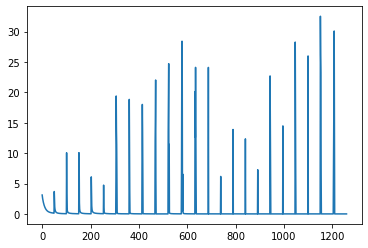

In [16]:
plt.plot(history["loss"])

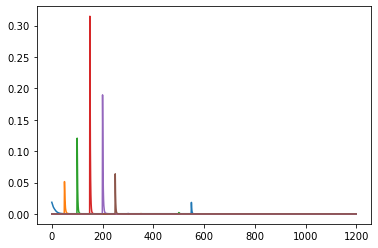

In [17]:
for i, ctx in enumerate(np.array(history["context_loss"]).T):
    plt.plot(ctx)

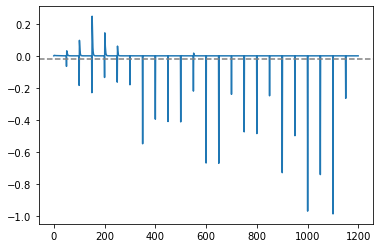

In [18]:
plt.plot(history["context_delta"])
plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")

In [19]:
total = 0
for ctx in range(NUM_TASKS):
    model.layers[2].set_context(ctx)
    pred = (model(x_train).numpy() >= 0.5).astype(dtype=np.int32)
    for i in range(len(y_train)):
        if np.all(pred == y_train[i]):
            total += 1
print(f"Accuarcy: {100*total/NUM_TASKS}%")

Accuarcy: 100.0%
